In [7]:
import requests
import gdax

def get_data():
    try:
        requestbody = requests.get("http://finvibby.herokuapp.com/live-data")
        price = float(requestbody.json()[1])
        return price
    except:
        get_data()
    


print(get_data())


7899.3


In [8]:
def current_range(data_pts=10):
    moving_price_list = []
    while len(moving_price_list) != data_pts:
        moving_price_list.append(get_data())
    return moving_price_list

print(current_range())

[7893.7, 7899.9, 7913.1, 7913.1, 7894.5, 7889.0, 7899.2, 7899.3, 7913.1, 7913.1]


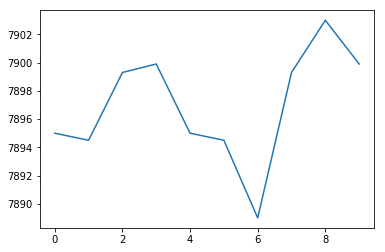

In [9]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


plt.plot(current_range())
plt.show()

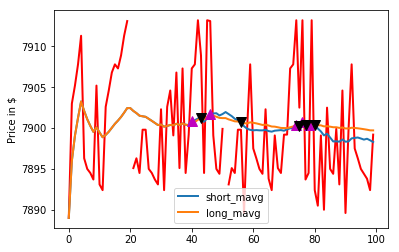

In [10]:
# Initialize the short and long windows
short_window = 40
long_window = 100
import pandas as pd
import numpy as np
# Initialize the `signals` DataFrame with the `signal` column
data_pts = 100
signals = pd.DataFrame({"price":current_range(data_pts)})



signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = signals['price'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = signals['price'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()


# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
signals['price'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()


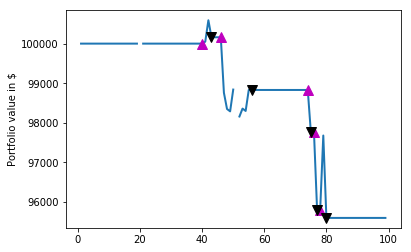

In [ ]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(signals['price'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(signals['price'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(signals['price'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()


import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()
plt.axes((100, 100, 100, 100))

In [ ]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = signals['price'].rolling(window, min_periods=1).max()
daily_drawdown = signals['price']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()


# Get the number of days in `aapl`
days = (signals.index[-1] - signals.index[0])
data_pts = 100
# Calculate the CAGR 
cagr = ((((signals['price'][data_pts-1]) / signals['price'][1])) ** (365.0/int(days)) - 1)

# Print CAGR
print(cagr)